## 가공된 남방톱날꽃게 데이터셋 분석 및 시각화를 통해 데이터셋 정제

### 1. 데이터셋 분석 및 시각화를 위해 필요한 라이브러리 import 하기

In [1]:
import pandas as pd
import numpy as np # 생략
import matplotlib.pyplot as plt
import seaborn as sns

### 2. 데이터셋 가져오기  
상대경로를 사용하여 한 번 가공된 데이터셋을 가져온다.

In [2]:
filepath = "./2_Data preparation.csv"

In [3]:
df = pd.read_csv(filepath)

In [4]:
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6
...,...,...,...,...,...,...,...,...,...
3856,F,1.4625,1.1375,0.3250,24.819987,11.651644,5.854172,6.378637,8
3857,F,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10
3858,I,0.6250,0.4625,0.1625,2.012815,0.765436,0.524466,0.637864,5
3859,I,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6


### 3. 산점도 그래프 그리기

In [5]:
col_val = df.columns.values

In [6]:
col_val

array(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'], dtype=object)

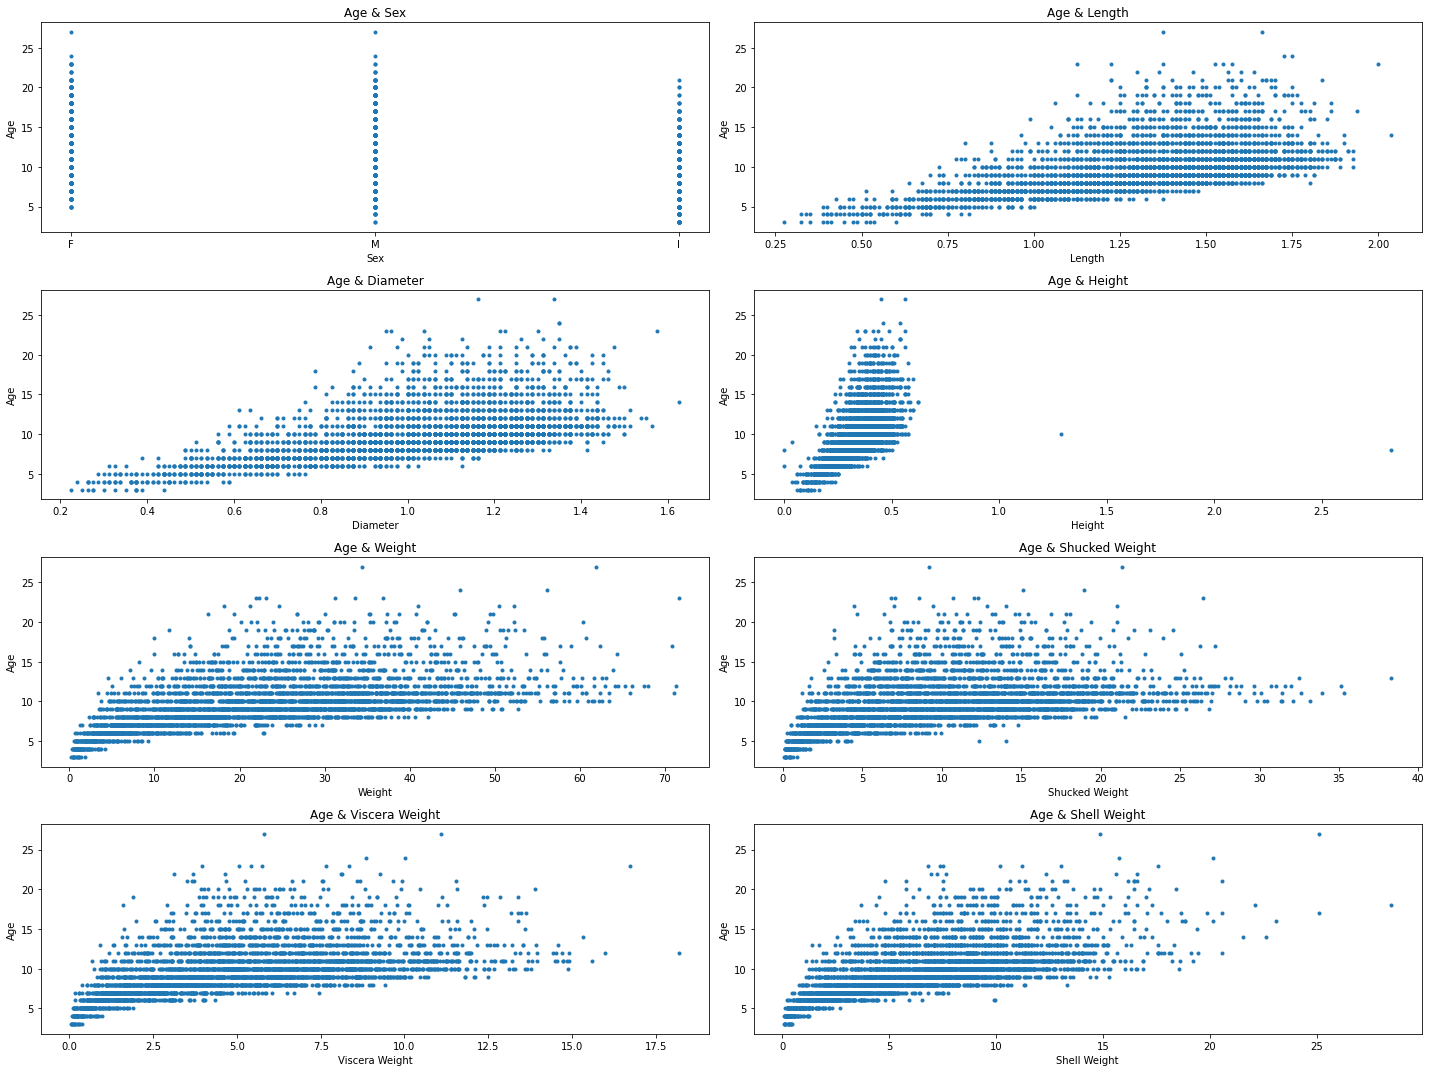

In [7]:
fig, axis = plt.subplots(4, 2, figsize=(20, 15))

cnt = 0

for x in range(4):
    for y in range(2):
        axis[x, y].plot(df[col_val[cnt]], df["Age"], 'o', markersize=3) # matplotlib라이브러리의 plot 함수를 이용해 그래프 그림 
        axis[x, y].set_title(f"Age & {col_val[cnt]}", size=12) # 그래프 제목
        axis[x, y].set_xlabel(col_val[cnt], size=10)
        axis[x, y].set_ylabel("Age", size=10)
        
        cnt+=1

fig.tight_layout()

위의 그래프를 보면 각 독립변수들이 종속변수와 양의 상관관계를 가짐을 확인할 수 있다. 그런데 나이가 많을 수록 독립변수들이 넓게 분포되어 꼬깔 모양의 형태를 이루고 있다. 이를 통해 나이가 많을 수록 각 개체들 간의 신체적 차이가 크다는 것을 알 수 있다.

### 4. 다시 이상치 제거하기  
이전의 전처리 과정에서는 나이별로 weight이상치를 제거하였다. 하지만 산점도 그래프를 보니 height이상치가 크게 나타남을 확인 할 수 있었다. 꽃게의 높이가 비정상적으로 큰 경우 때문에 Age & Height 그래프가 왼쪽으로 치우쳐 있다. 딥러닝 모델의 정확도를 높이기 위해 나이별로 height이상치를 제거하고자 한다. 

평균에서 +/- 3표준편차를 넘어서는 이상치를 제거하는 함수

In [8]:
def is_outliers(s):
    upper_limit = s.mean() + (s.std()*3)
    lower_limit = s.mean() - (s.std()*3)
    return ~s.between(lower_limit, upper_limit)

In [9]:
df_out = df[~df.groupby('Age')['Height'].apply(is_outliers)]

이상치 제거 전/후 비교

In [10]:
print("height이상치 제거전:", df.shape)
print("height이상치 제거후:", df_out.shape)

height이상치 제거전: (3861, 9)
height이상치 제거후: (3852, 9)


#### 다시 산점도 그래프 그리기  
다시 그려본 결과 Age & Height 그래프가 다른 그래프들과 비슷한 선형적인 형태로 나타남을 확인할 수 있었다.

In [11]:
col_val2 = df_out.columns.values

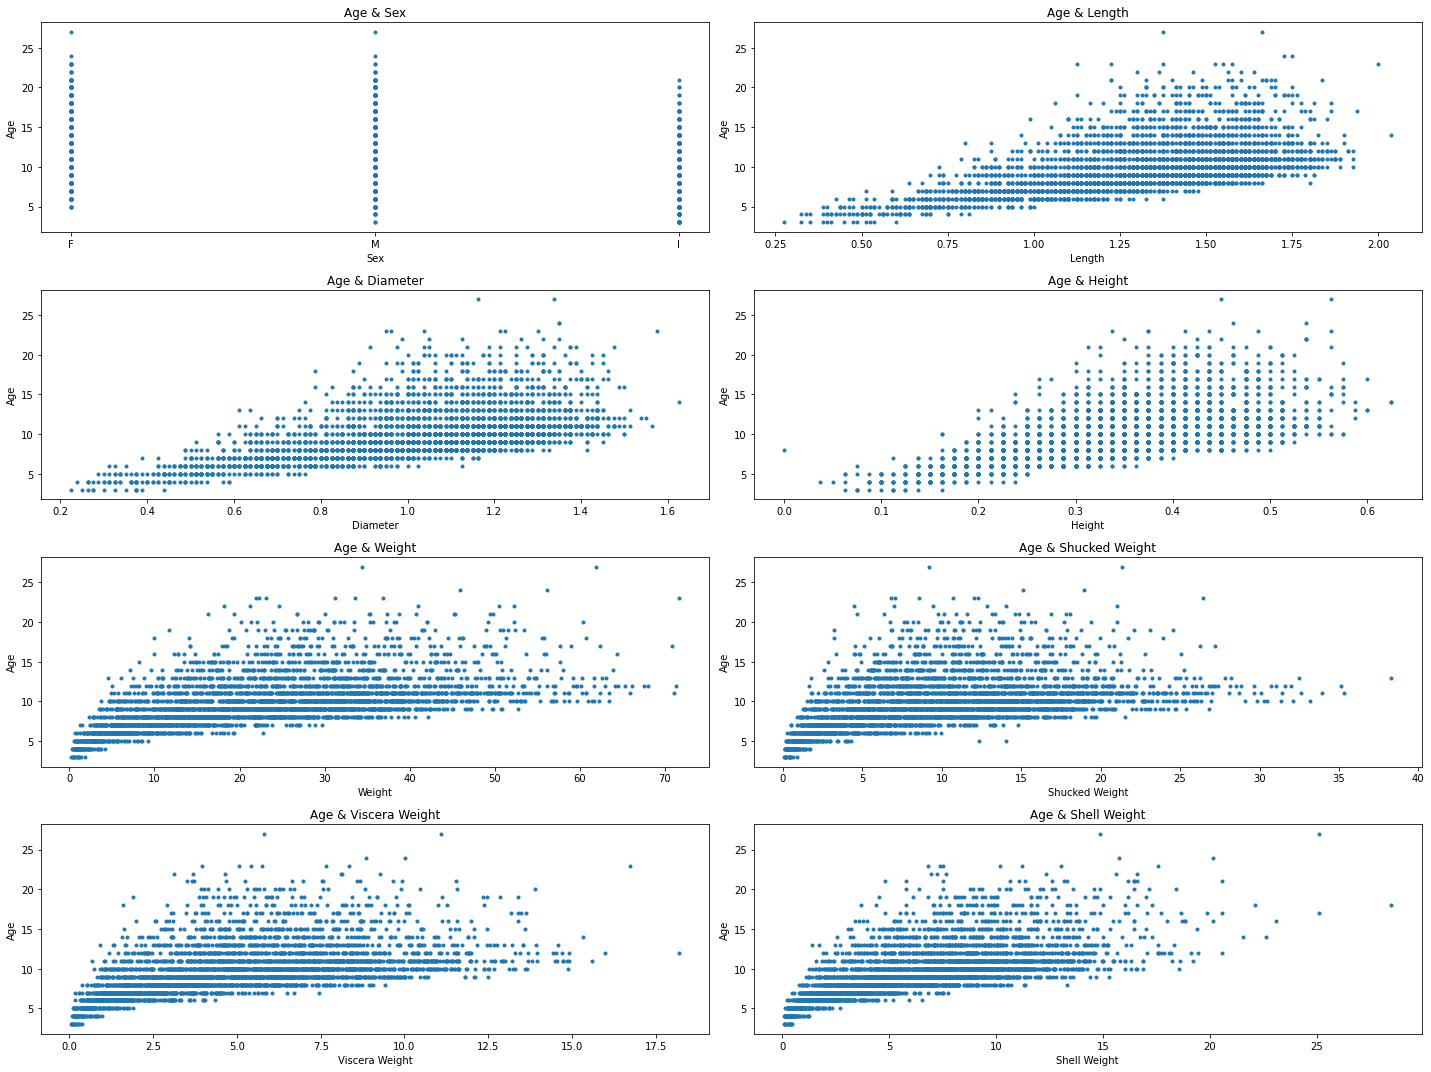

In [12]:
fig, axis = plt.subplots(4, 2, figsize=(20, 15))

cnt = 0

for x in range(4):
    for y in range(2):
        axis[x, y].plot(df_out[col_val2[cnt]], df_out["Age"], 'o', markersize=3)  # matplotlib라이브러리의 plot 함수를 이용해 그래프 그림
        axis[x, y].set_title(f"Age & {col_val2[cnt]}", size=12)  # 그래프 제목
        axis[x, y].set_xlabel(col_val2[cnt], size=10)
        axis[x, y].set_ylabel("Age", size=10)
        
        cnt+=1

fig.tight_layout()

### 5. 상관도 그래프 그리기  
seaborn 라이브러리에서 제공하는 pairplot() 함수를 이용해 상관도 그래프를 그려보았다. 성별에 따라 점의 색을 다르게 표현하였다(그래프 그리는데 30초 정도의 시간 소요).  
F: 암컷(파란색), M: 수컷(주황색), I: 중간단계(초록색)  
전체적으로 양의 선형 관계가 나타남을 알 수 있다.

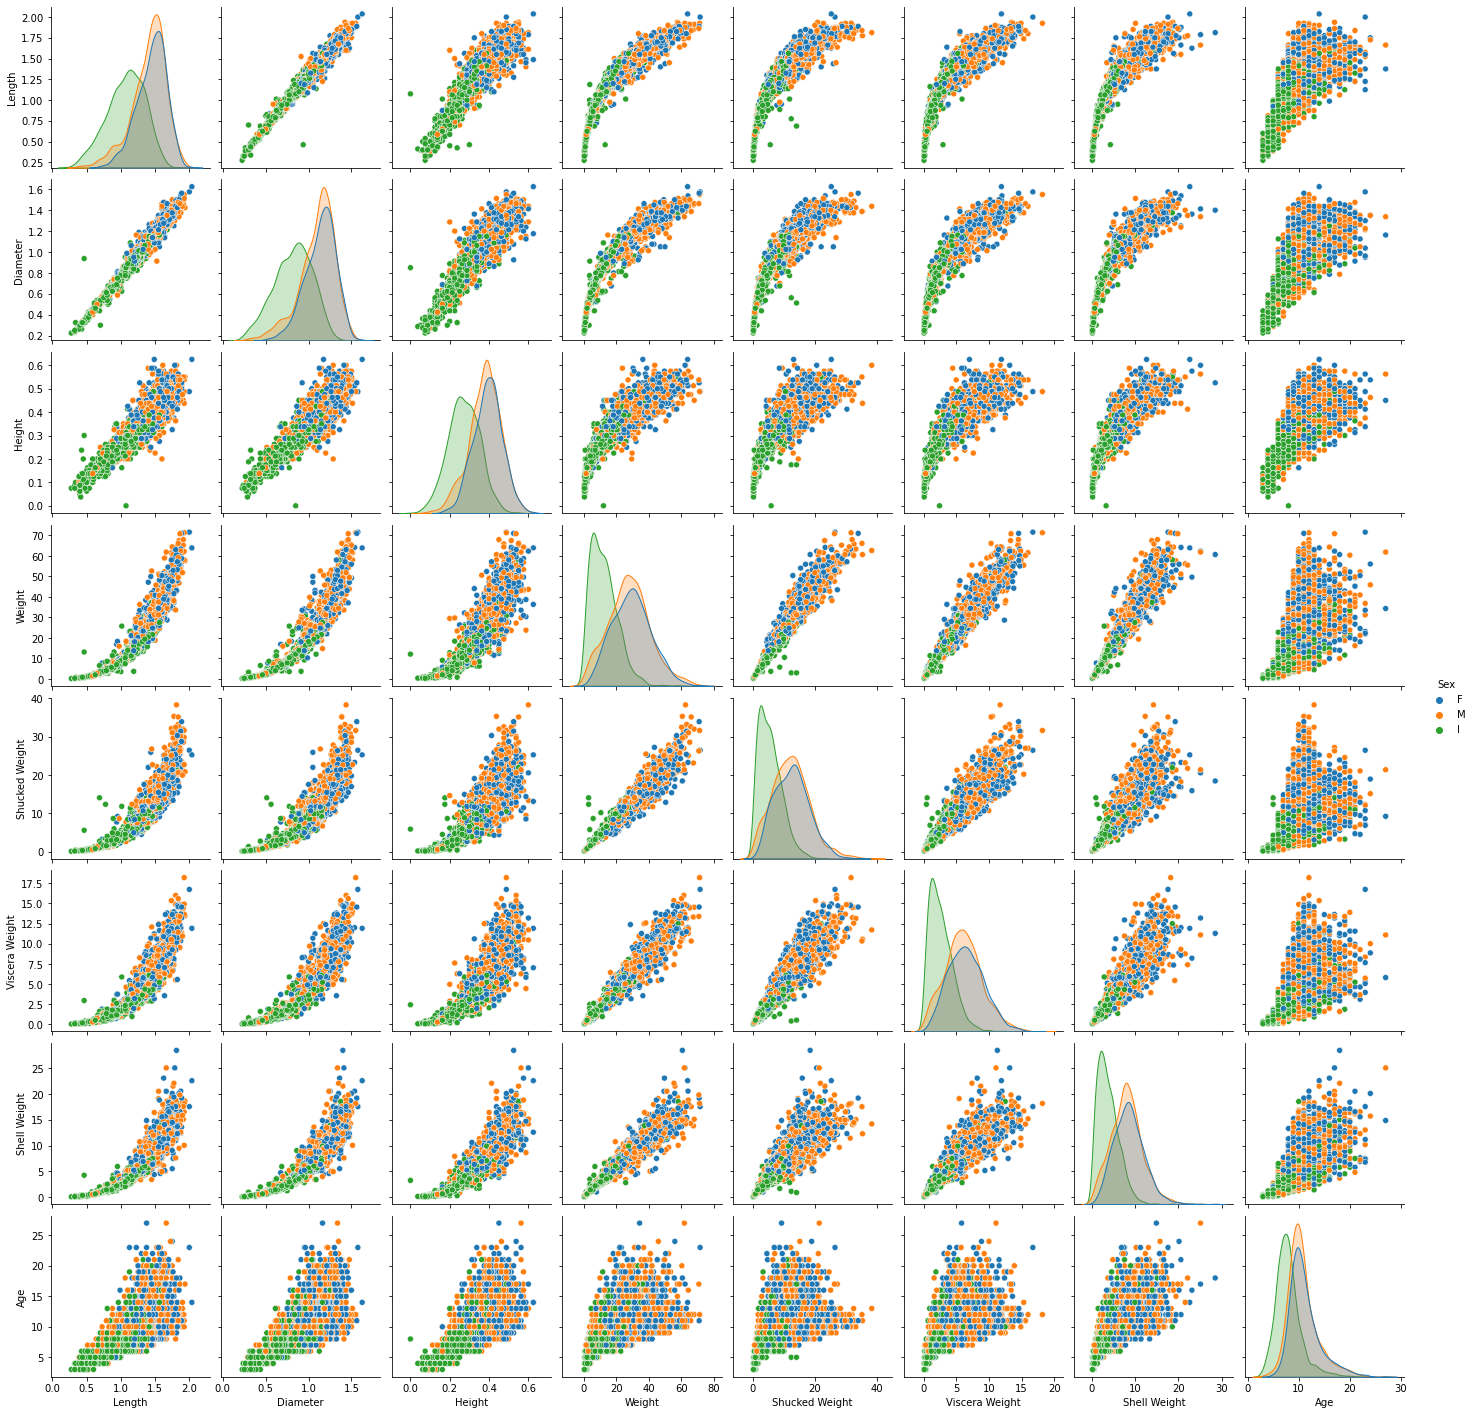

In [13]:
sns.pairplot(df_out, hue='Sex')
plt.show()

### 7. Heatmap 그래프를 이용해 데이터의 상관관계를 시각화하기  
여기서 나타나는 상관계수는 피어슨 상관계수이다.  
matplotlib.pyplot에서 제공하는 색상 구성을 사용

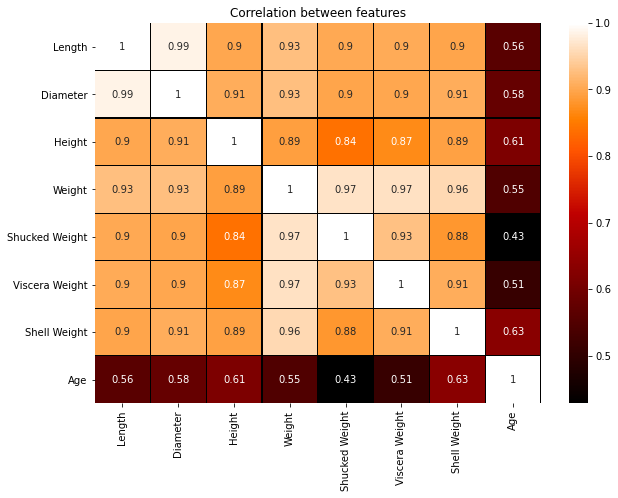

In [14]:
plt.figure(figsize=(10,7)) #그래프의 크기

sns.heatmap(df_out.corr(), cmap=plt.cm.gist_heat, linewidths=0.1, linecolor='black', annot=True)
plt.title("Correlation between features")
plt.show()

색상을 cmap=Greens 으로 변경하기

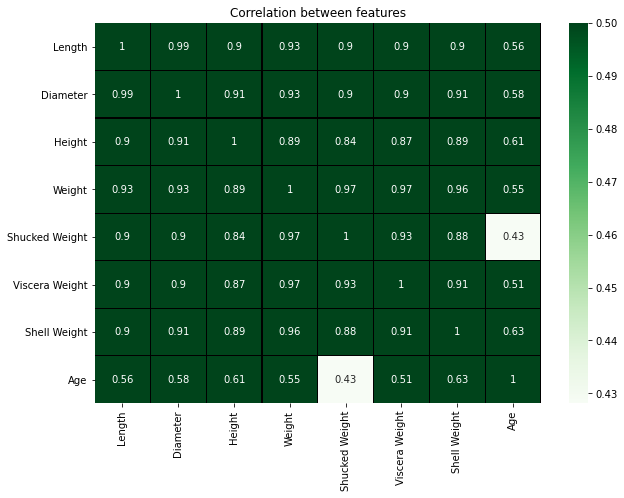

In [15]:
plt.figure(figsize=(10,7)) #그래프의 크기

# vmax를 0.5로 설정: 0.5이상부터 초록색으로 표시됨
sns.heatmap(df_out.corr(), cmap=plt.cm.Greens, linewidths=0.1, vmax=0.5, linecolor='black', annot=True) 
plt.title("Correlation between features")
plt.show()

피어슨 상관계수가 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계를 나타낸다고 한다. 위의 heatmap 그래프를 보면 각 변수들 간에는 뚜렷한 양적 선형관계가 나타난다. 그러나 age와 shucked weight의 상관계수가 0.43으로 Age와 다른 변수들의 상관계수에 비해서는 상대적으로 작음을 알 수 있다. 그리고 shucked weight는 age를 제외한 다른 변수들과의 상관계수가 모두 +0.7과 +1.0 사이로, 강한 양적 선형관계를 나타낸다. 즉, shucked weight는 다른 변수들에 상당히 종속적이라고 생각할 수 있다. 따라서 불필요한 shucked weight를 데이터에서 제거하여 차후 딥러닝 분석시 너무 많은 변수들로 인한 오버피팅의 위험성을 낮추고자 한다.  

In [16]:
df_out2 = df_out.drop("Shucked Weight", axis=1)

In [17]:
df_out2

,Sex,Length,Diameter,Height,Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,1.488349,1.700970,6
...,...,...,...,...,...,...,...,...
3856,F,1.4625,1.1375,0.3250,24.819987,5.854172,6.378637,8
3857,F,1.5500,1.2125,0.4375,34.458817,7.172423,9.780577,10
3858,I,0.6250,0.4625,0.1625,2.012815,0.524466,0.637864,5
3859,I,1.0625,0.7750,0.2625,10.347568,2.338834,2.976698,6


### 8. 성별을 이진수로 변환하기-> 원-핫 인코딩(One-Hot Encoding)  
게의 경우, 어릴 때는 성별이 정해져 있는 상태가 아니다. 데이터를 수집한 사람의 말에 의하면 게들의 성별은 생후 5~6개월 이전에 대부분 결정되고, 그 이후에 성별을 판별할 수 있는 신체적 특성이 발달하기 시작한다고 한다. 나는 회귀분석을 하기 위해 성별 데이터를 더미 처리를 하여 이진수로 표현하고자 한다. 성별이 F, M, I의 세 가지이기 때문에 3개의 가변수가 생성된다.

In [18]:
df_out3 = pd.get_dummies(df_out2, columns=['Sex'])

df_out3.head(6)

,Length,Diameter,Height,Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.4375,1.1750,0.4125,24.635715,5.584852,6.747181,9,1,0,0
1,0.8875,0.6500,0.2125,5.400580,1.374951,1.559222,6,0,0,1
2,1.0375,0.7750,0.2500,7.952035,1.601747,2.764076,6,0,1,0
3,1.1750,0.8875,0.2500,13.480187,2.282135,5.244657,10,1,0,0
4,0.8875,0.6625,0.2125,6.903103,1.488349,1.700970,6,0,1,0
5,1.5500,1.1625,0.3500,28.661344,6.761356,7.229122,8,1,0,0


In [19]:
df_out3.shape

(3852, 10)

### 9. 정제된 데이터셋 저장

In [20]:
df_out3.to_csv("3_Dataset.csv",encoding="utf-8-sig",index=False)